## 2.0 Doping,  k=-49.0 to 49.0

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import h5py

from scipy import ndimage

import time
import sys
sys.path.append('/share/kim/XTEC/src/xtec')

#%reload_ext autoreload
#%autoreload 2

from Preprocessing import Mask_Zeros
from Preprocessing import Threshold_Background
from GMM import GMM


In [2]:
# read data, and Qh,Qk,Ql values
h5py_data_key = 'entry/transform/data/'

DIR = '/share/kim/STEM_Xray_data/xray_from_Josh_Straquadine/PdxErTe3_2x0/b5653/PdxErTe3_2x0_'
Tlist = [30,40,50,60,70,80,90,100,110,115,120,125,130,135,140,145,150,155,160,170,180,190,200,210,220,230,245,260,280] #T=30


filepaths = [DIR + str(T) + 'K.nxs' for T in Tlist]


doc = h5py.File(filepaths[0], 'r')
    
Qh=np.array(doc['entry/transform']['Qh'])
Qk=np.array(doc['entry/transform']['Qk'])
Ql=np.array(doc['entry/transform']['Ql'])



In [3]:
H_Bragg_loc=np.array(Qh%1==0)
K_Bragg_loc=np.array(Qk%1==0)
L_Bragg_loc=np.array(Ql%1==0)

Qh_Bragg=Qh[np.where(H_Bragg_loc)]
Qk_Bragg=Qk[np.where(K_Bragg_loc)]
Ql_Bragg=Ql[np.where(L_Bragg_loc)]



H_Bragg_ind=np.array(np.where(H_Bragg_loc)).flatten()
L_Bragg_ind=np.array(np.where(L_Bragg_loc)).flatten()
K_Bragg_ind=np.array(np.where(K_Bragg_loc)).flatten()

Qk_ind=K_Bragg_ind[abs(Qk[K_Bragg_ind])<=49]
cpu_counter=range(len(Qk_ind))

print('Data considered here:')
print('Qh = ', Qh)
print('Ql = ', Ql)
print('Qk = ', Qk[Qk_ind])



Data considered here:
Qh =  [-10.    -9.98  -9.96 ...   9.96   9.98  10.  ]
Ql =  [-10.    -9.98  -9.96 ...   9.96   9.98  10.  ]
Qk =  [-49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37. -36.
 -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23. -22.
 -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.
  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.
   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.
  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.
  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.
  49.]


In [4]:
import pickle
#pickle.dump( processed_data, open( "processed_data_No_Mask_2x0.p", "wb" ) )
processed_data = pickle.load(open("processed_data_No_Mask_2x0.p", "rb" ) )


# CDW along c*

In [5]:
I_BG_list=[]
NB_avg_list = []
NB_tot_list = []
NB_max_list = []
NB_mom_list = []
NB_data_list=[]

NB_label_list = []
threshold_list=[]
labeled_array_list=[]

for num, slices in enumerate(processed_data):
    Tlist=slices['Tlist']
    #I_BG_list.append(slices['I_BG'])
    NB_data_list.append(slices['NonBragg_data'])
    NB_avg_list.append(slices['NB_avg'])
    NB_tot_list.append(slices['NB_tot'])
    NB_max_list.append(slices['NB_max'])
    NB_mom_list.append(slices['NB_mom'])
    
  
    NB_label_list.append(slices['NB_label'])
    
    threshold_list.append(slices['threshold_c'])
    labeled_array_list.append(slices['labeled_array'])

NB_avg  = np.hstack(NB_avg_list)  #(num_T, num_NB_data)
NB_tot  = np.hstack(NB_tot_list)  #(num_T, num_NB_data)
NB_max  = np.hstack(NB_max_list)  #(num_T, num_NB_data)
NB_mom  = np.vstack(NB_mom_list)  #(num_T, num_NB_data)

NB_data = np.hstack(NB_data_list)  #(num_T, num_NB_data)
#I_BG    = np.hstack(I_BG_list)  #(num_T, num_NB_data)

NB_label = np.hstack(NB_label_list)  #(num_NB_data) labels for the non bragg data

print(NB_avg.shape)
print(NB_tot.shape)
print(NB_max.shape)
print(NB_mom.shape)

print(NB_data.shape)
#print(I_BG.shape)



#I_BG_mean=np.mean(I_BG,axis=1)
#I_BG_std=np.std(I_BG,axis=1)
#print(I_BG_mean.shape)


(29, 38335)
(29, 38335)
(29, 38335)
(38335, 3)
(29, 256986)


## Clustering

In [6]:
x_train = np.array(Tlist)

#data_post_thresh = NB_avg

data_post_thresh = np.log(NB_max)
data_post_thresh_no_mean = (data_post_thresh-np.mean(data_post_thresh,axis=0)) #threshold.Rescale_traj(data_post_thresh)

#data_post_thresh = NB_avg
#data_post_thresh_no_mean = (data_post_thresh-np.mean(data_post_thresh,axis=0))/(1+np.std(data_post_thresh,axis=0)) #threshold.Rescale_traj(data_post_thresh)

y_train=data_post_thresh_no_mean.transpose() 

print('Data shape',y_train.shape)


Data shape (38335, 29)


In [36]:
from sklearn import  mixture
ks = np.arange(2,15)
bics = []
print(y_train.shape)
for k in ks:
    gmm = mixture.GaussianMixture(n_components=k, covariance_type='diag')
    gmm.fit(y_train)
    bics.append(gmm.bic(y_train))
    








(38335, 29)


/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/share/apps/anaconda3/2021.05/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Tr

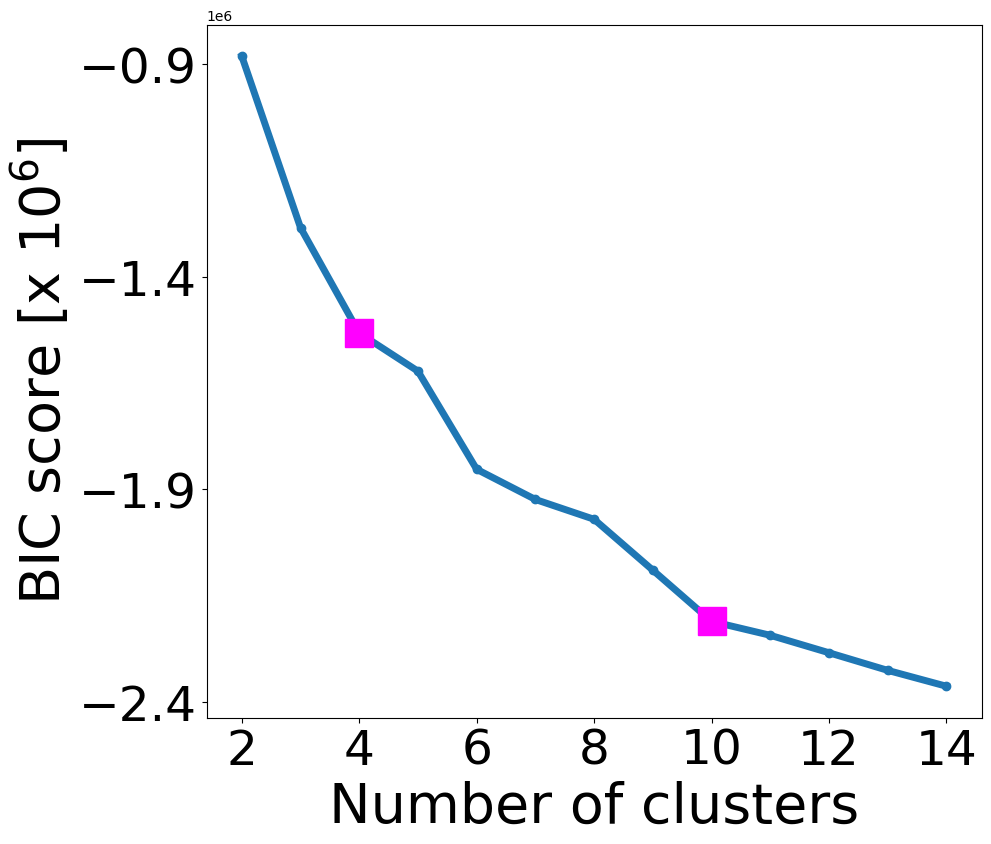

In [98]:
# Plot the data    
plt.figure(figsize=(10,9))
plt.plot(ks, bics,marker='o', lw=5)
plt.plot([4,10], [bics[2],bics[8]],marker='s',color='magenta',markersize=20,lw=0)

plt.xlabel(r'Number of clusters',size=40)
plt.ylabel(r'BIC score [x $10^6$]',size=40)
plt.xticks(fontsize=35);
plt.yticks( np.arange(-2.4e6,-0.5e6,0.5e6),fontsize=35);





# plot 10 clusters

In [101]:
clusterGMM=pickle.load(open( "First_clusterGMM_2x0_10C.p", "rb" ))
cluster_assignments = clusterGMM.cluster_assignments


In [102]:
color_list = ['teal',  'thistle','grey','blue', 'red', 'orange', 'pink', 'grey', 'cyan','purple','maroon','magenta']
line_list= [':',':',':','-','-.',':',':',':',':',':']
lw_list=[2.5,2.5,2.5,4,4,2.5,2.5,2.5,2.5,2.5,2.5]
alpha_list=[0.2,0.2,0.2,0.6,0.6,0.2,0.2,0.2,0.2,0.2]


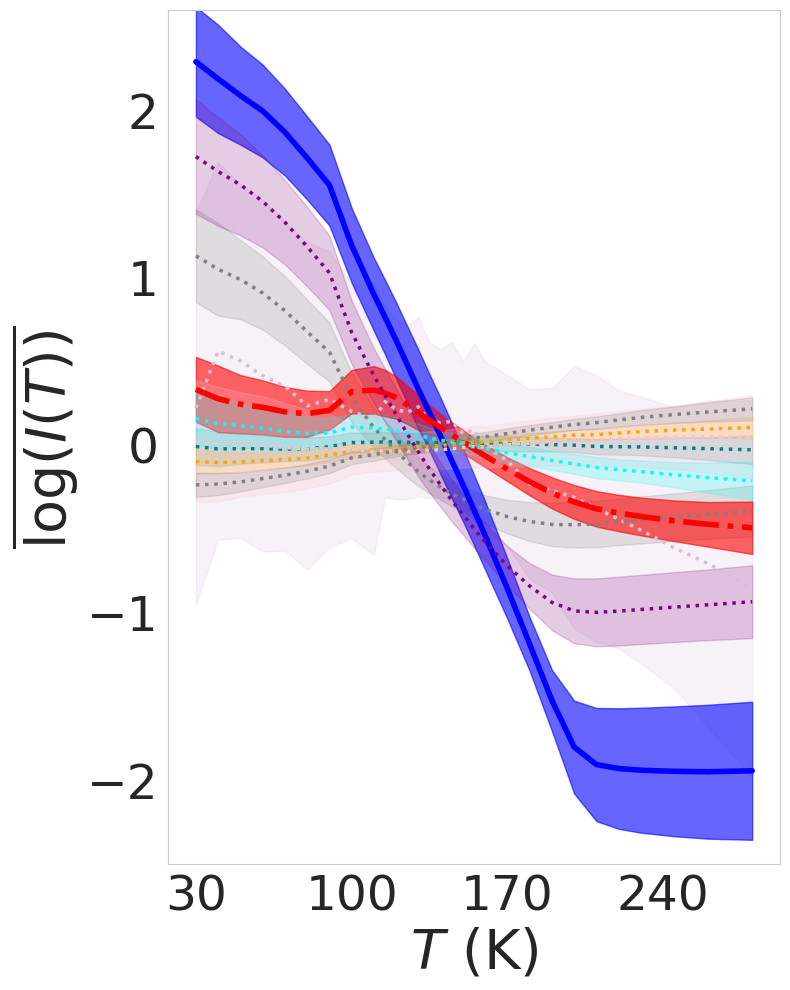

In [103]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,10))



x_train=np.array(Tlist)

for i in range(clusterGMM.cluster_num):
    cluster_mask_i = (clusterGMM.cluster_assignments == i)
    yc = y_train.transpose()
    yc=yc[:,cluster_mask_i]

    yc_plot=np.mean(yc,axis=1).flatten()
    std=np.std(yc,axis=1).flatten()
    plt.plot(np.array(Tlist),yc_plot,color=color_list[i], lw=lw_list[i],marker=' ', linestyle=line_list[i]);
    plt.gca().fill_between(x_train, yc_plot-std, yc_plot+std ,color=color_list[i], alpha=alpha_list[i])


plt.xlabel('$T$ (K)',size=40)
plt.ylabel(r'$\overline{\log\left(I(T)\right)}$',size=40)
plt.xticks(np.arange(30, 310, 70), fontsize=35)
plt.yticks(fontsize=35)
plt.ylim([-2.5,2.6])

plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()



# Plot 4 clusters

In [107]:
clusterGMM=pickle.load(open( "First_clusterGMM_2x0_4C.p", "rb" ))
cluster_assignments = clusterGMM.cluster_assignments


In [82]:
CDW_clusters=[2,3]


T = np.array(Tlist)
I_raw = NB_avg
I_rescaled=y_train

cluster_num=clusterGMM.cluster_num
GMM_means = [clusterGMM.cluster[k].mean for k in range(cluster_num)]
GMM_cov = [clusterGMM.cluster[k].cov for k in range(cluster_num)]


CDW_trajs  = np.isin(cluster_assignments, CDW_clusters)
I_rescaled_CDW=I_rescaled[CDW_trajs,:]






In [108]:
color_list = ['purple',  'thistle','red','blue', 'grey', 'orange', 'pink', 'black', 'grey', 'cyan','teal','maroon','magenta']
line_list= [':',':','-.','-',':',':']
lw_list=[3.5,2.5,4,4,2.5,2.5]
alpha_list=[0.2,0.2,0.5,0.5,0.2,0.2,0.2]






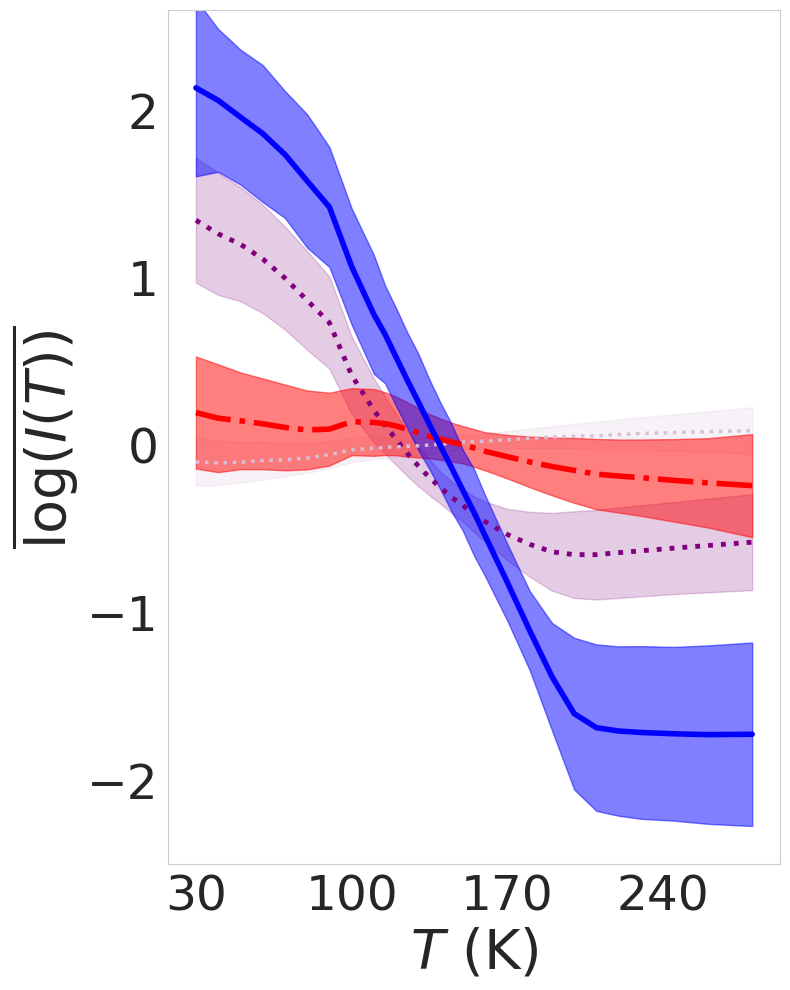

In [130]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,10))



x_train=np.array(Tlist)

for i in range(clusterGMM.cluster_num):
    cluster_mask_i = (clusterGMM.cluster_assignments == i)
    yc = y_train.transpose()
    yc=yc[:,cluster_mask_i]

    yc_plot=np.mean(yc,axis=1).flatten()
    std=np.std(yc,axis=1).flatten()
    plt.plot(np.array(Tlist),yc_plot,color=color_list[i], lw=lw_list[i],marker=' ', linestyle=line_list[i]);
    plt.gca().fill_between(x_train, yc_plot-std, yc_plot+std ,color=color_list[i], alpha=alpha_list[i])


plt.xlabel('$T$ (K)',size=40)
plt.ylabel(r'$\overline{\log\left(I(T)\right)}$',size=40)
plt.xticks(np.arange(30, 310, 70), fontsize=35)
plt.yticks(fontsize=35)
plt.ylim([-2.5,2.6])
#plt.yscale('log')
#plt.ylim([30,3000])

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=35)
#plt.legend(loc='best', fontsize=30,frameon=False)

plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()

#plt.savefig('CDW_1_2_0x0.svg')   
#plt.savefig('CDW_1_2_0x0.png',dpi=600)   


## undo rescaling

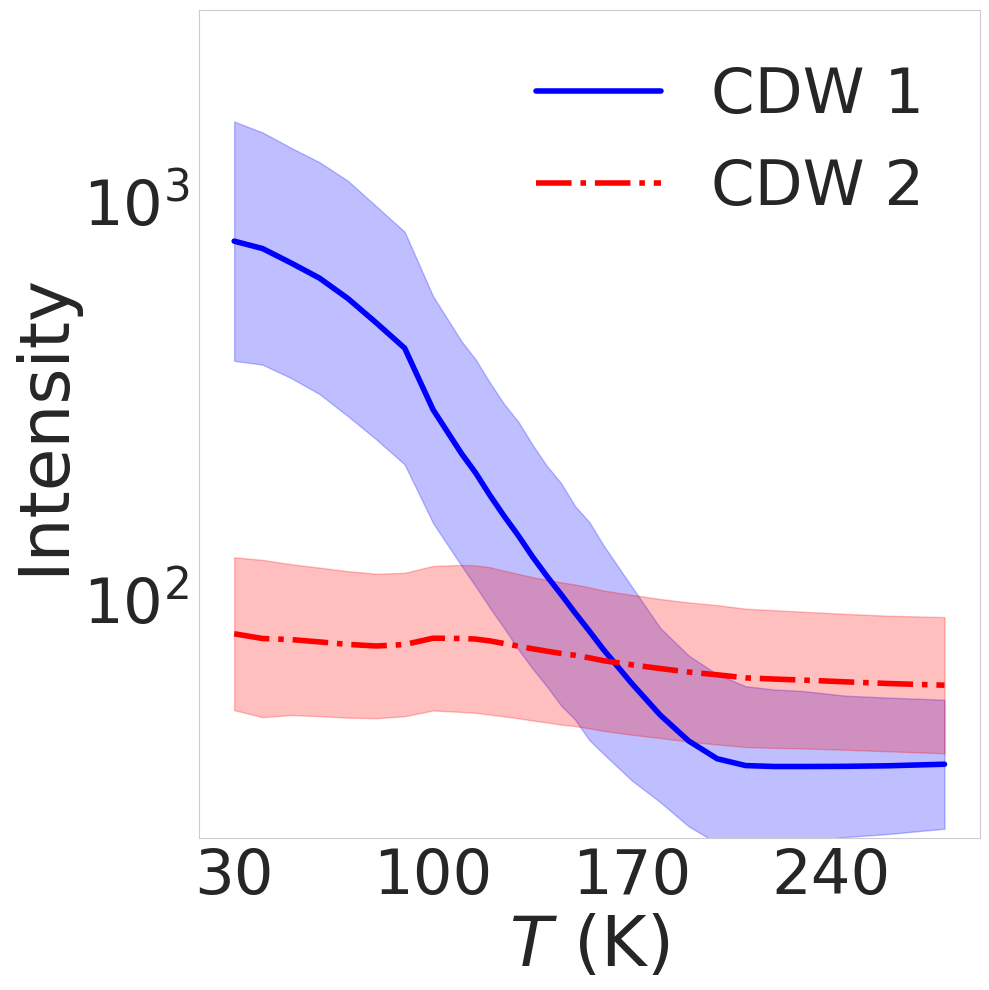

In [136]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
#color_list = ['red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink', 'black', 'grey', 'cyan']
#color_list = ['red', 'blue', 'green', 'purple', 'yellow', 'orange', 'pink', 'black', 'grey', 'cyan']
data=np.log10(NB_avg)
x_train=np.array(Tlist)
std_dev_num=1



# ................CDW-1............................
i=3
cluster_mask_i = (clusterGMM.cluster_assignments == i)
yc_plot=np.mean(data[:,cluster_mask_i],axis=1).flatten()
std= np.std(data[:,cluster_mask_i],axis=1).flatten()   

plt.plot(x_train,10**yc_plot,color='blue', lw=4,linestyle='-',marker=' ',markersize=8, label='CDW 1');
plt.gca().fill_between(x_train, 10**(yc_plot-std), 10**(yc_plot+std) , color='blue', alpha=0.25)

#xc=[260]
#yc=(10**yc_plot)[-4]
#plt.plot(xc,yc,marker="o", markersize=15,color='black',linestyle='None')



# ................CDW-2............................

i=2

cluster_mask_i = (clusterGMM.cluster_assignments == i)
yc_plot=np.mean(data[:,cluster_mask_i],axis=1).flatten()
std= np.std(data[:,cluster_mask_i],axis=1).flatten()   

plt.plot(x_train,10**yc_plot,color='red', lw=4,linestyle='-.', marker=' ',markersize=10,label='CDW 2');
plt.gca().fill_between(x_train, 10**(yc_plot-std), 10**(yc_plot+std) , color='red', alpha=0.25)





#xc=[135]
#yc=(10**yc_plot)[4]
#plt.plot(xc,yc,marker='s', markersize=15,color='black',linestyle='None')








plt.xlabel('$T$ (K)',size=50)
plt.ylabel(r'Intensity',size=50)
plt.xticks(np.arange(30, 310, 70), fontsize=45)
plt.yticks(fontsize=45)

plt.yscale('log')
plt.ylim([25,3000])

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=35)
plt.legend(loc='best', fontsize=45,frameon=False)

plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()

plt.savefig('CDW_1_2_0x0.svg')   
plt.savefig('CDW_1_2_0x0.png',dpi=600)   



# Look at momentum distribution of CDW

In [96]:
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_slice(K_block):
    # ...............Just for a lighter shade of sky blue for background...................................

    K=Qk[Qk_ind[K_block]]
    print('K=', K)
    
    plotting_slice = threshold_list[K_block].thresholded.copy()
    labeled_array=labeled_array_list[K_block]


    for k in range(cluster_num):
        cluster_labels = NB_label[(cluster_assignments == k)]
        cluster_mask   = np.isin(labeled_array,cluster_labels)           # returns true for labeled arrays that match  NonBragg_labels
        plotting_slice[cluster_mask] = k+2
    
    color_list1= ['white','whitesmoke']+color_list
    cluster_cmap = colors.ListedColormap(color_list1)
    
    bounds = []
    for i in range(len(color_list1)+1):
        bounds.append(i-0.5)
    norm = colors.BoundaryNorm(bounds,cluster_cmap.N)




    fig=plt.figure(figsize=(5,5),dpi=600)
    ax = fig.add_subplot(1, 1, 1)
    y_major_ticks = np.array(Qh_Bragg)
    x_major_ticks = np.array(Ql_Bragg)
    ax.set_yticks(y_major_ticks)
    ax.set_xticks(x_major_ticks)
    if(K%2==0): 
        ax.set_title(r'$K$ = '+str(K), fontsize=25)
    else:
        ax.set_title(r'$K$ = '+str(K), fontsize=25)
        
    ax.set_xlabel('$H$ (r.l.u.)', fontsize=25)
    ax.set_ylabel('$L$ (r.l.u.)', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.imshow(plotting_slice[775-200:925-200,175+500:325+500],origin='lower',cmap=cluster_cmap,norm=norm,extent=[Ql[175+500], Ql[325+500],Qh[775-200], Qh[925-200]])
    #plt.imshow(plotting_slice,origin='lower',cmap=cluster_cmap,norm=norm,extent=[Ql[0], Ql[-1],Qh[0], Qh[-1]])
    
    #plt.imshow(plotting_slice[775:925,75:225],origin='lower',cmap=cluster_cmap,norm=norm,extent=[Ql[75], Ql[225],Qh[775], Qh[925]])
    plt.grid(color='#999999', linestyle='-', alpha=0.05)
    
    plt.rcParams['svg.fonttype'] = 'none'
    plt.tight_layout()

    #plt.savefig('CDW_12_slice_K_'+str(K)+'_0x0.svg') 
    #plt.savefig('CDW_12_slice_K_'+str(K)+'_0x0.png',dpi=600) 
    



    

K= 1.0
K= 2.0
K= 3.0
K= 4.0


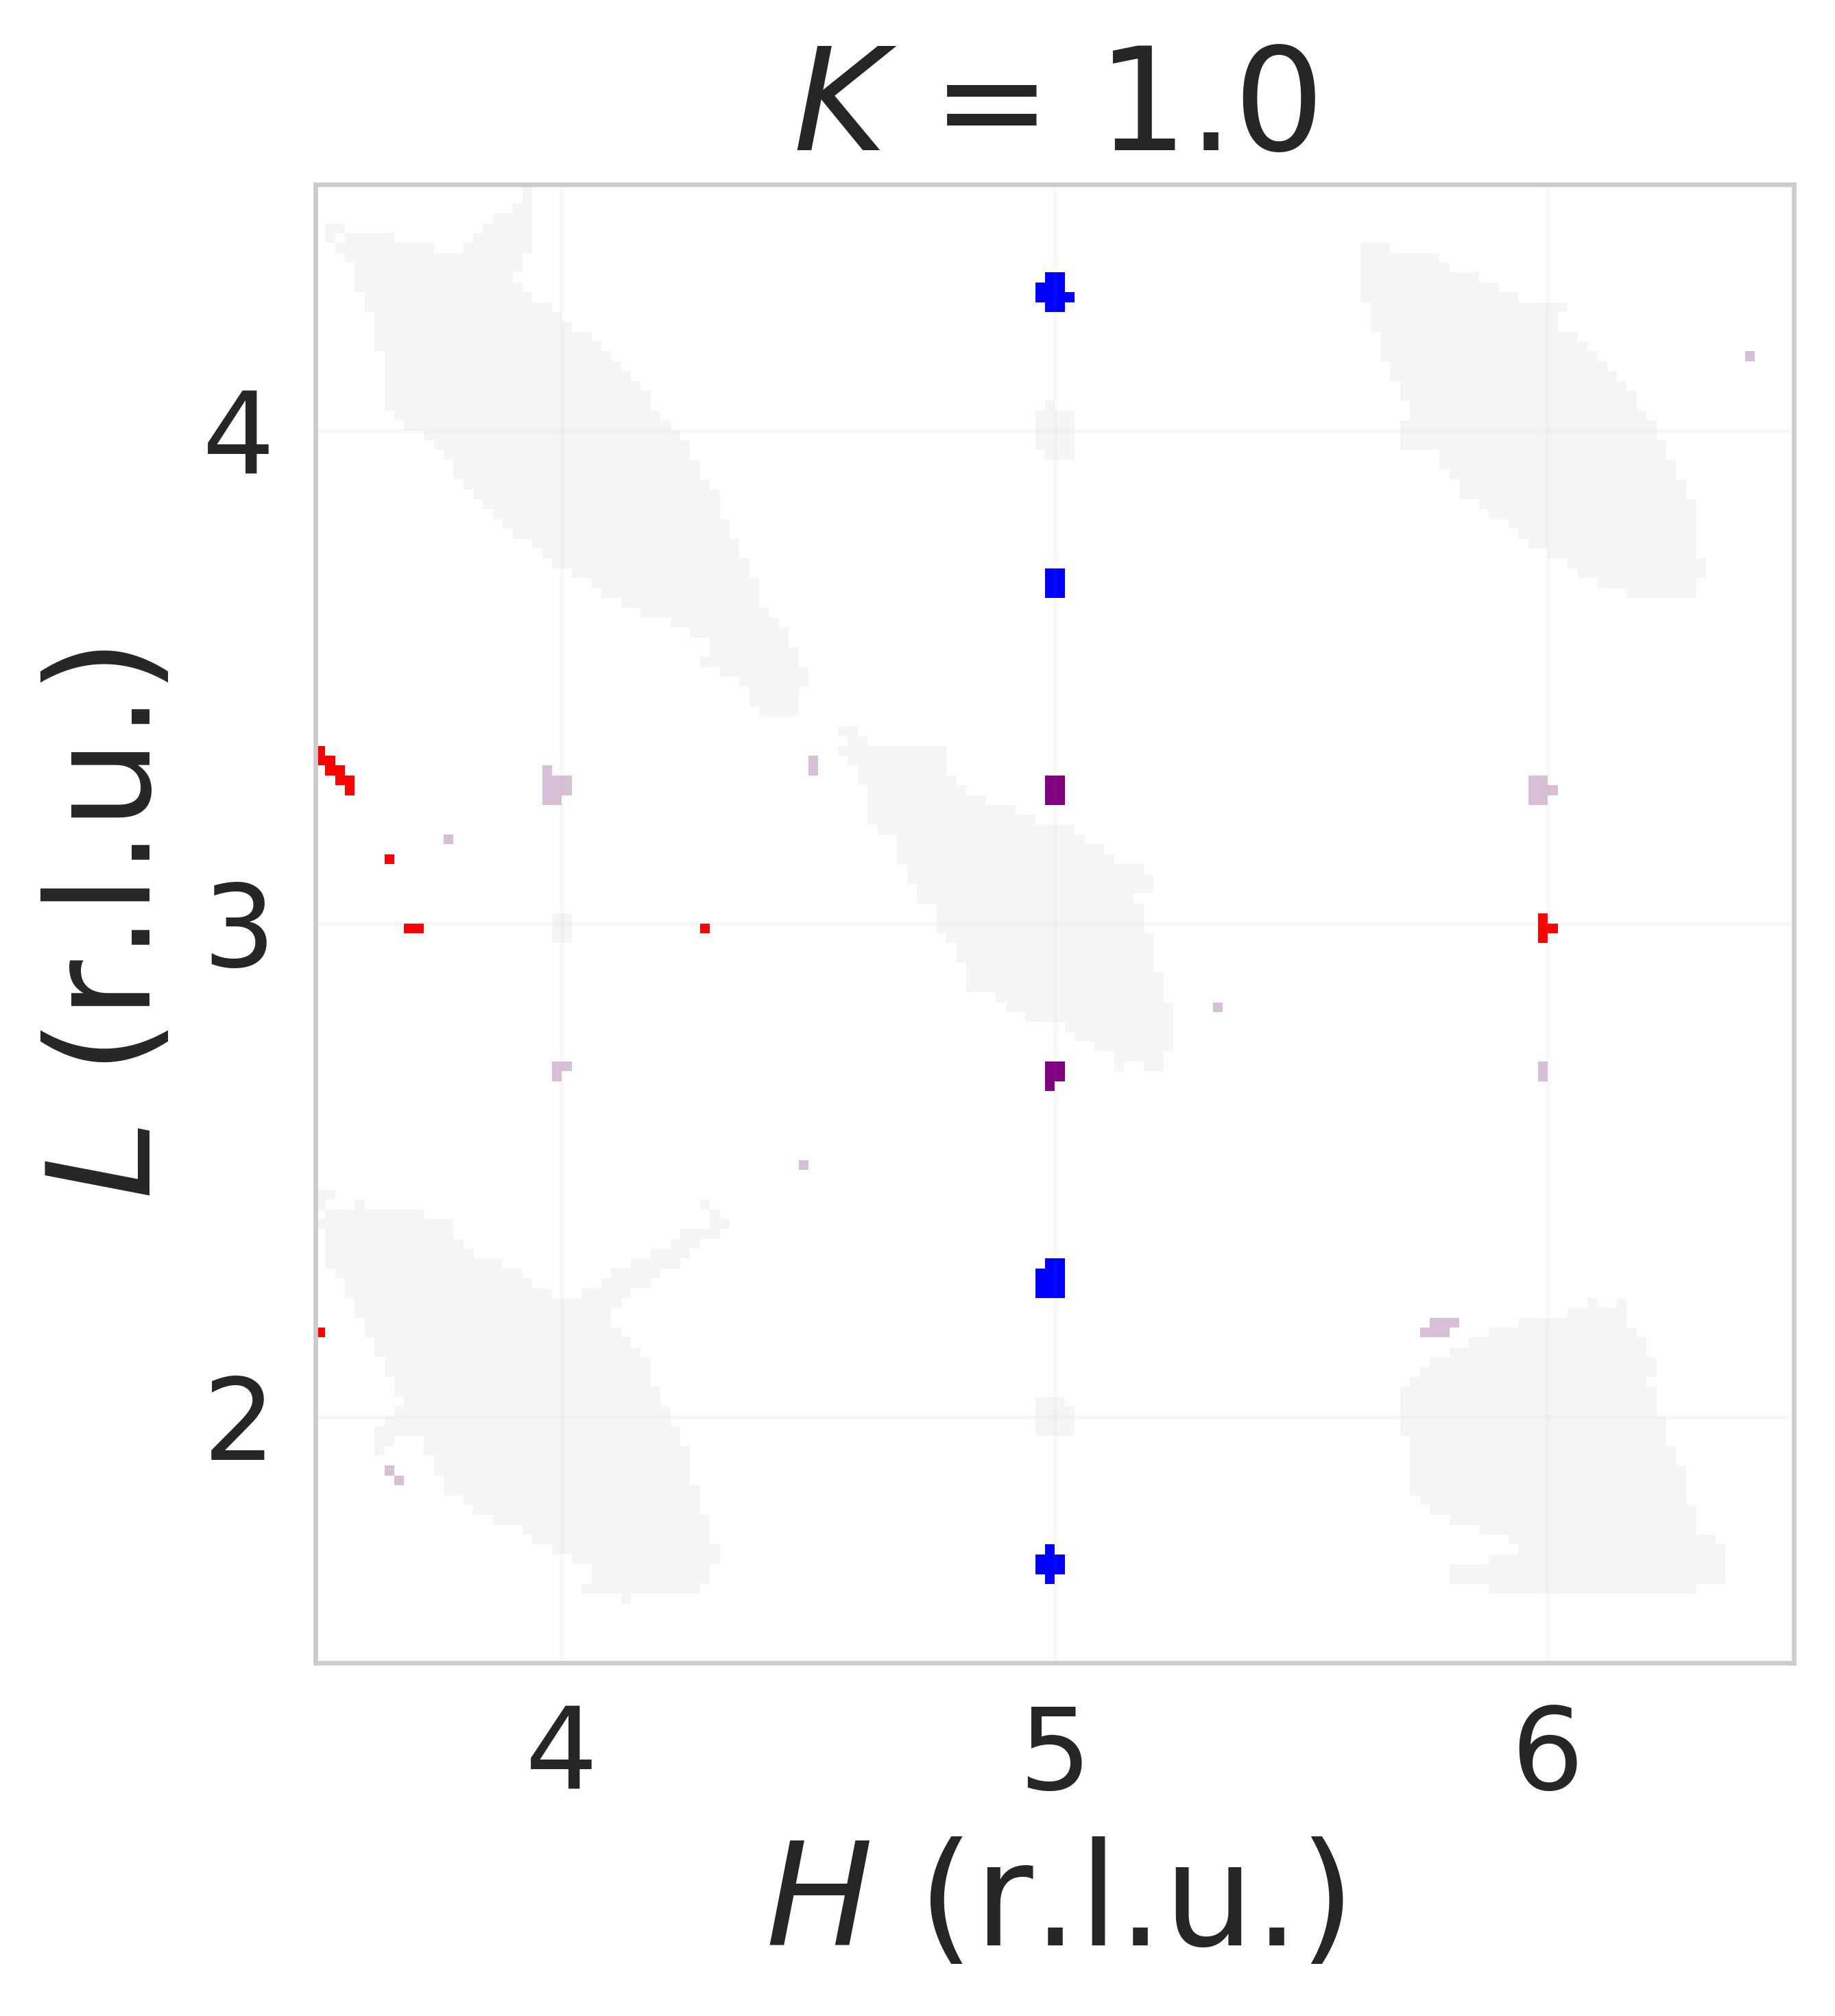

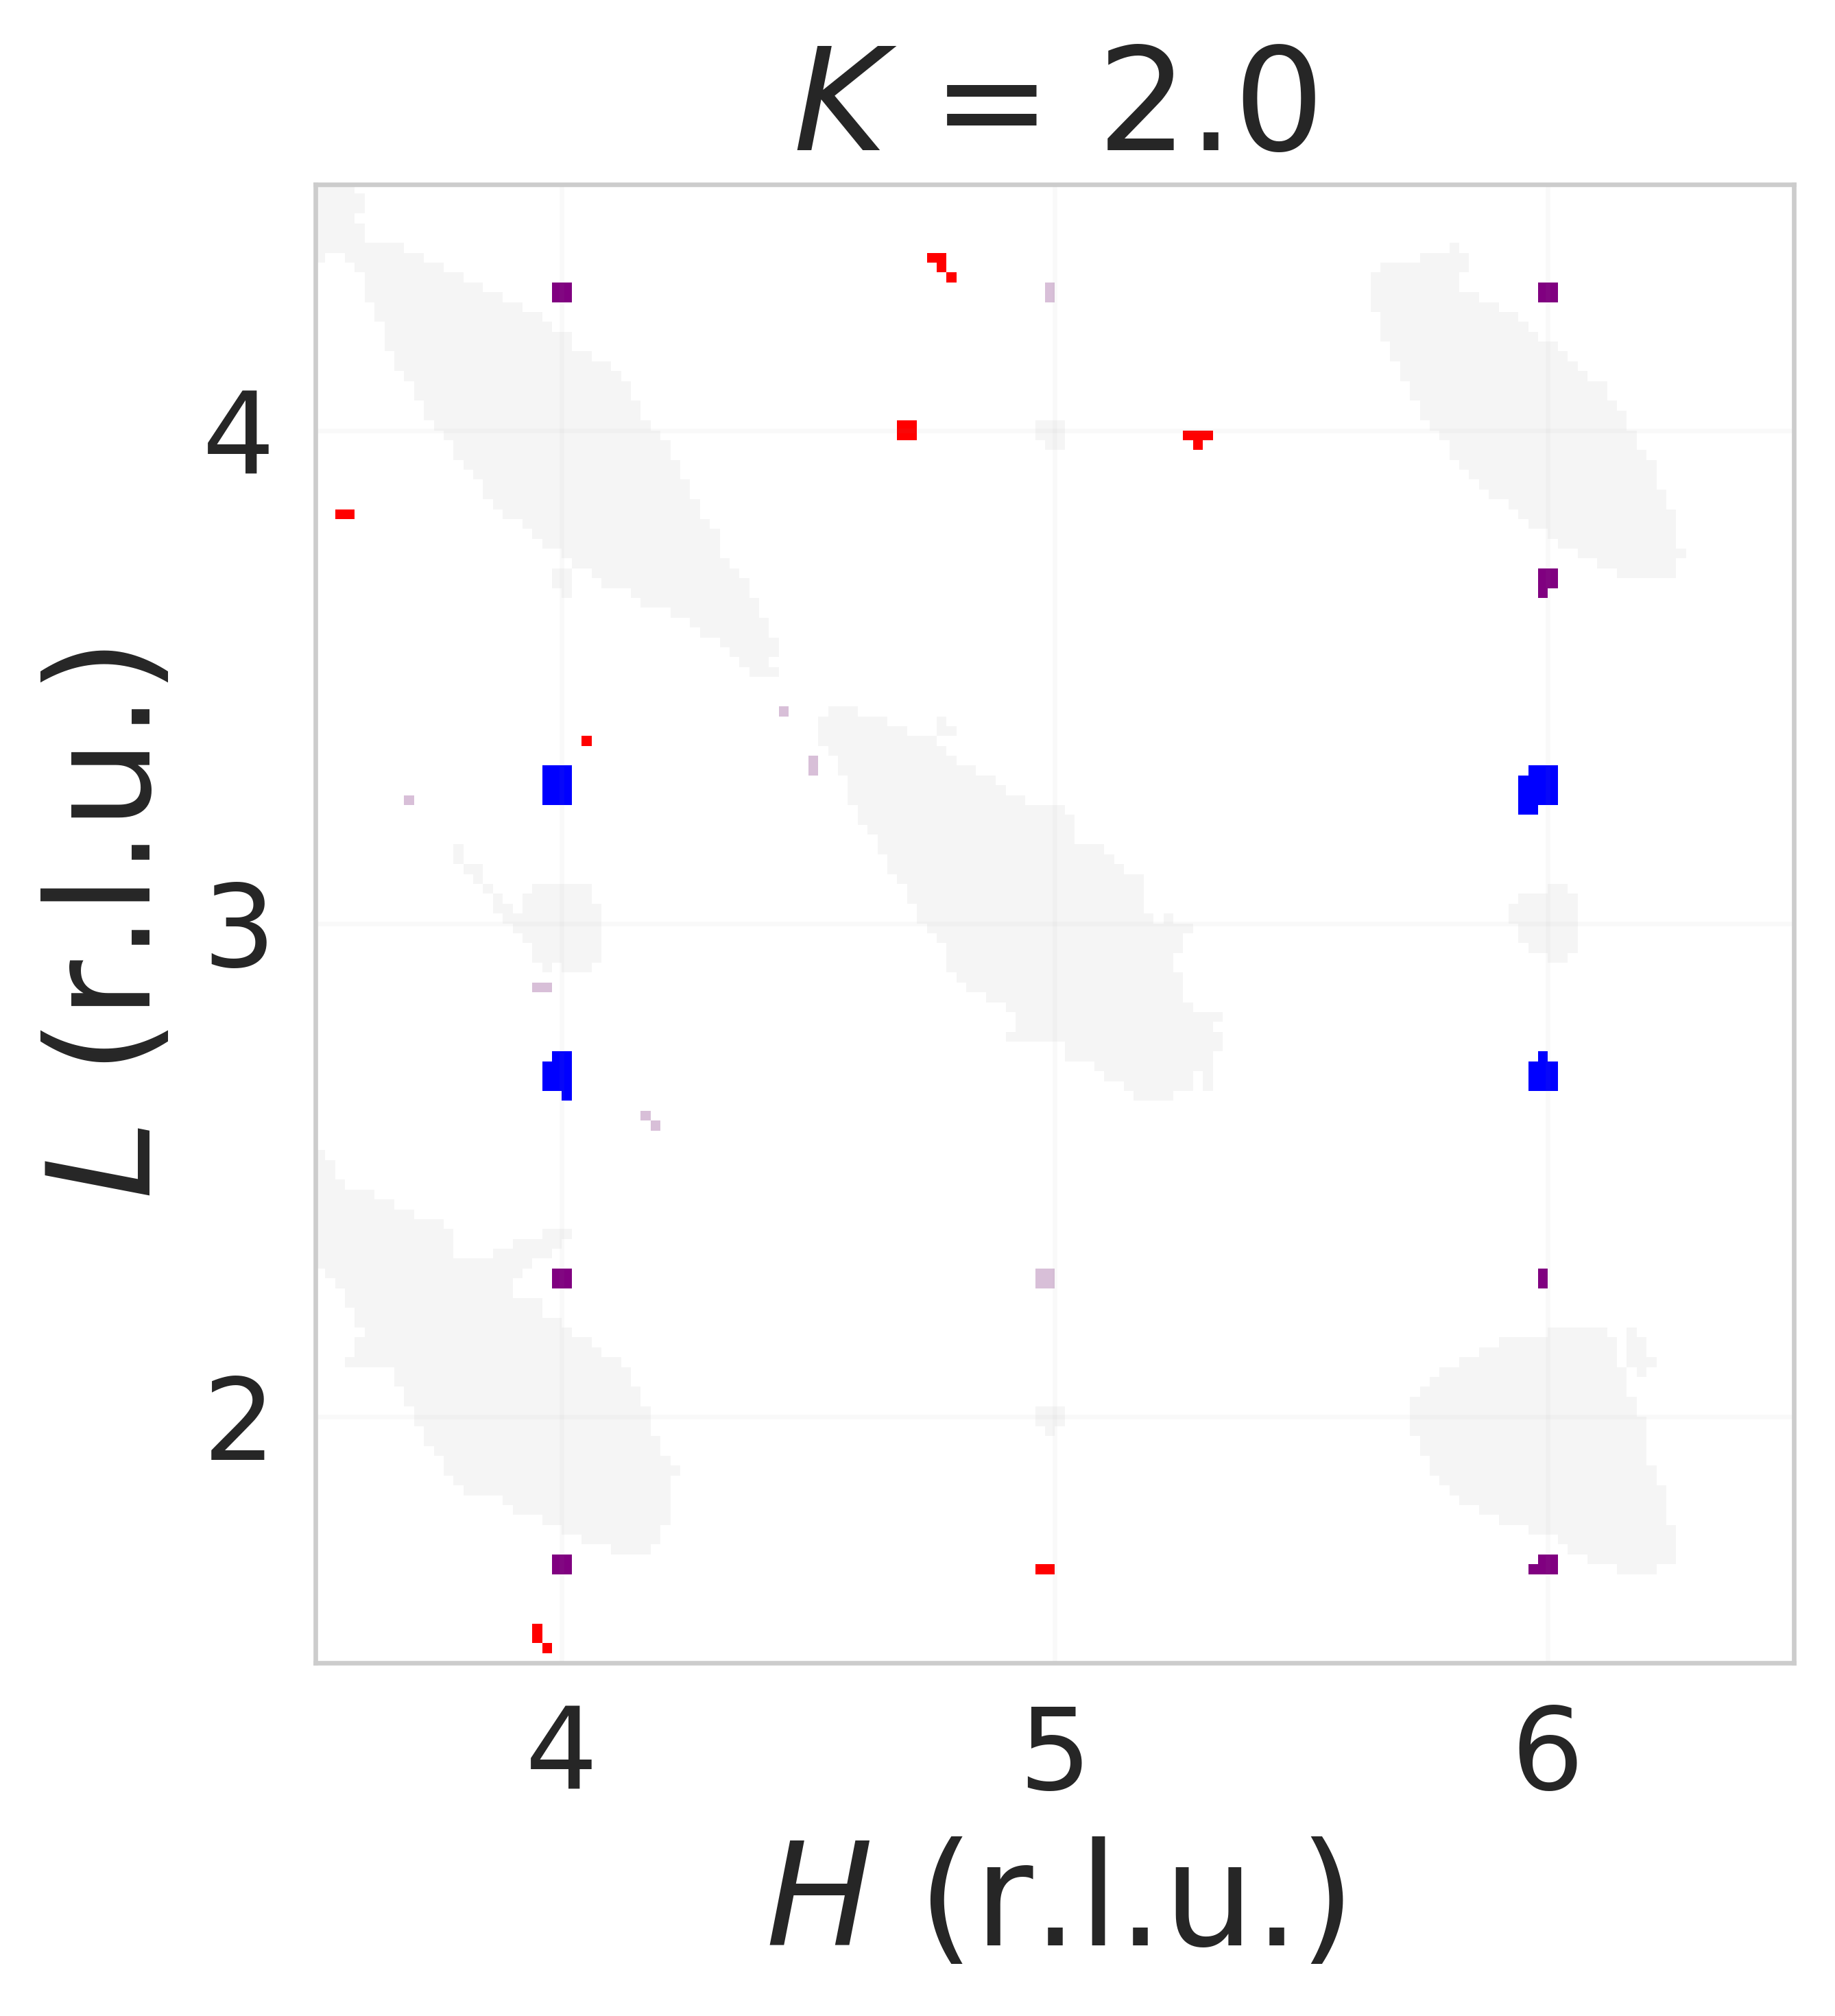

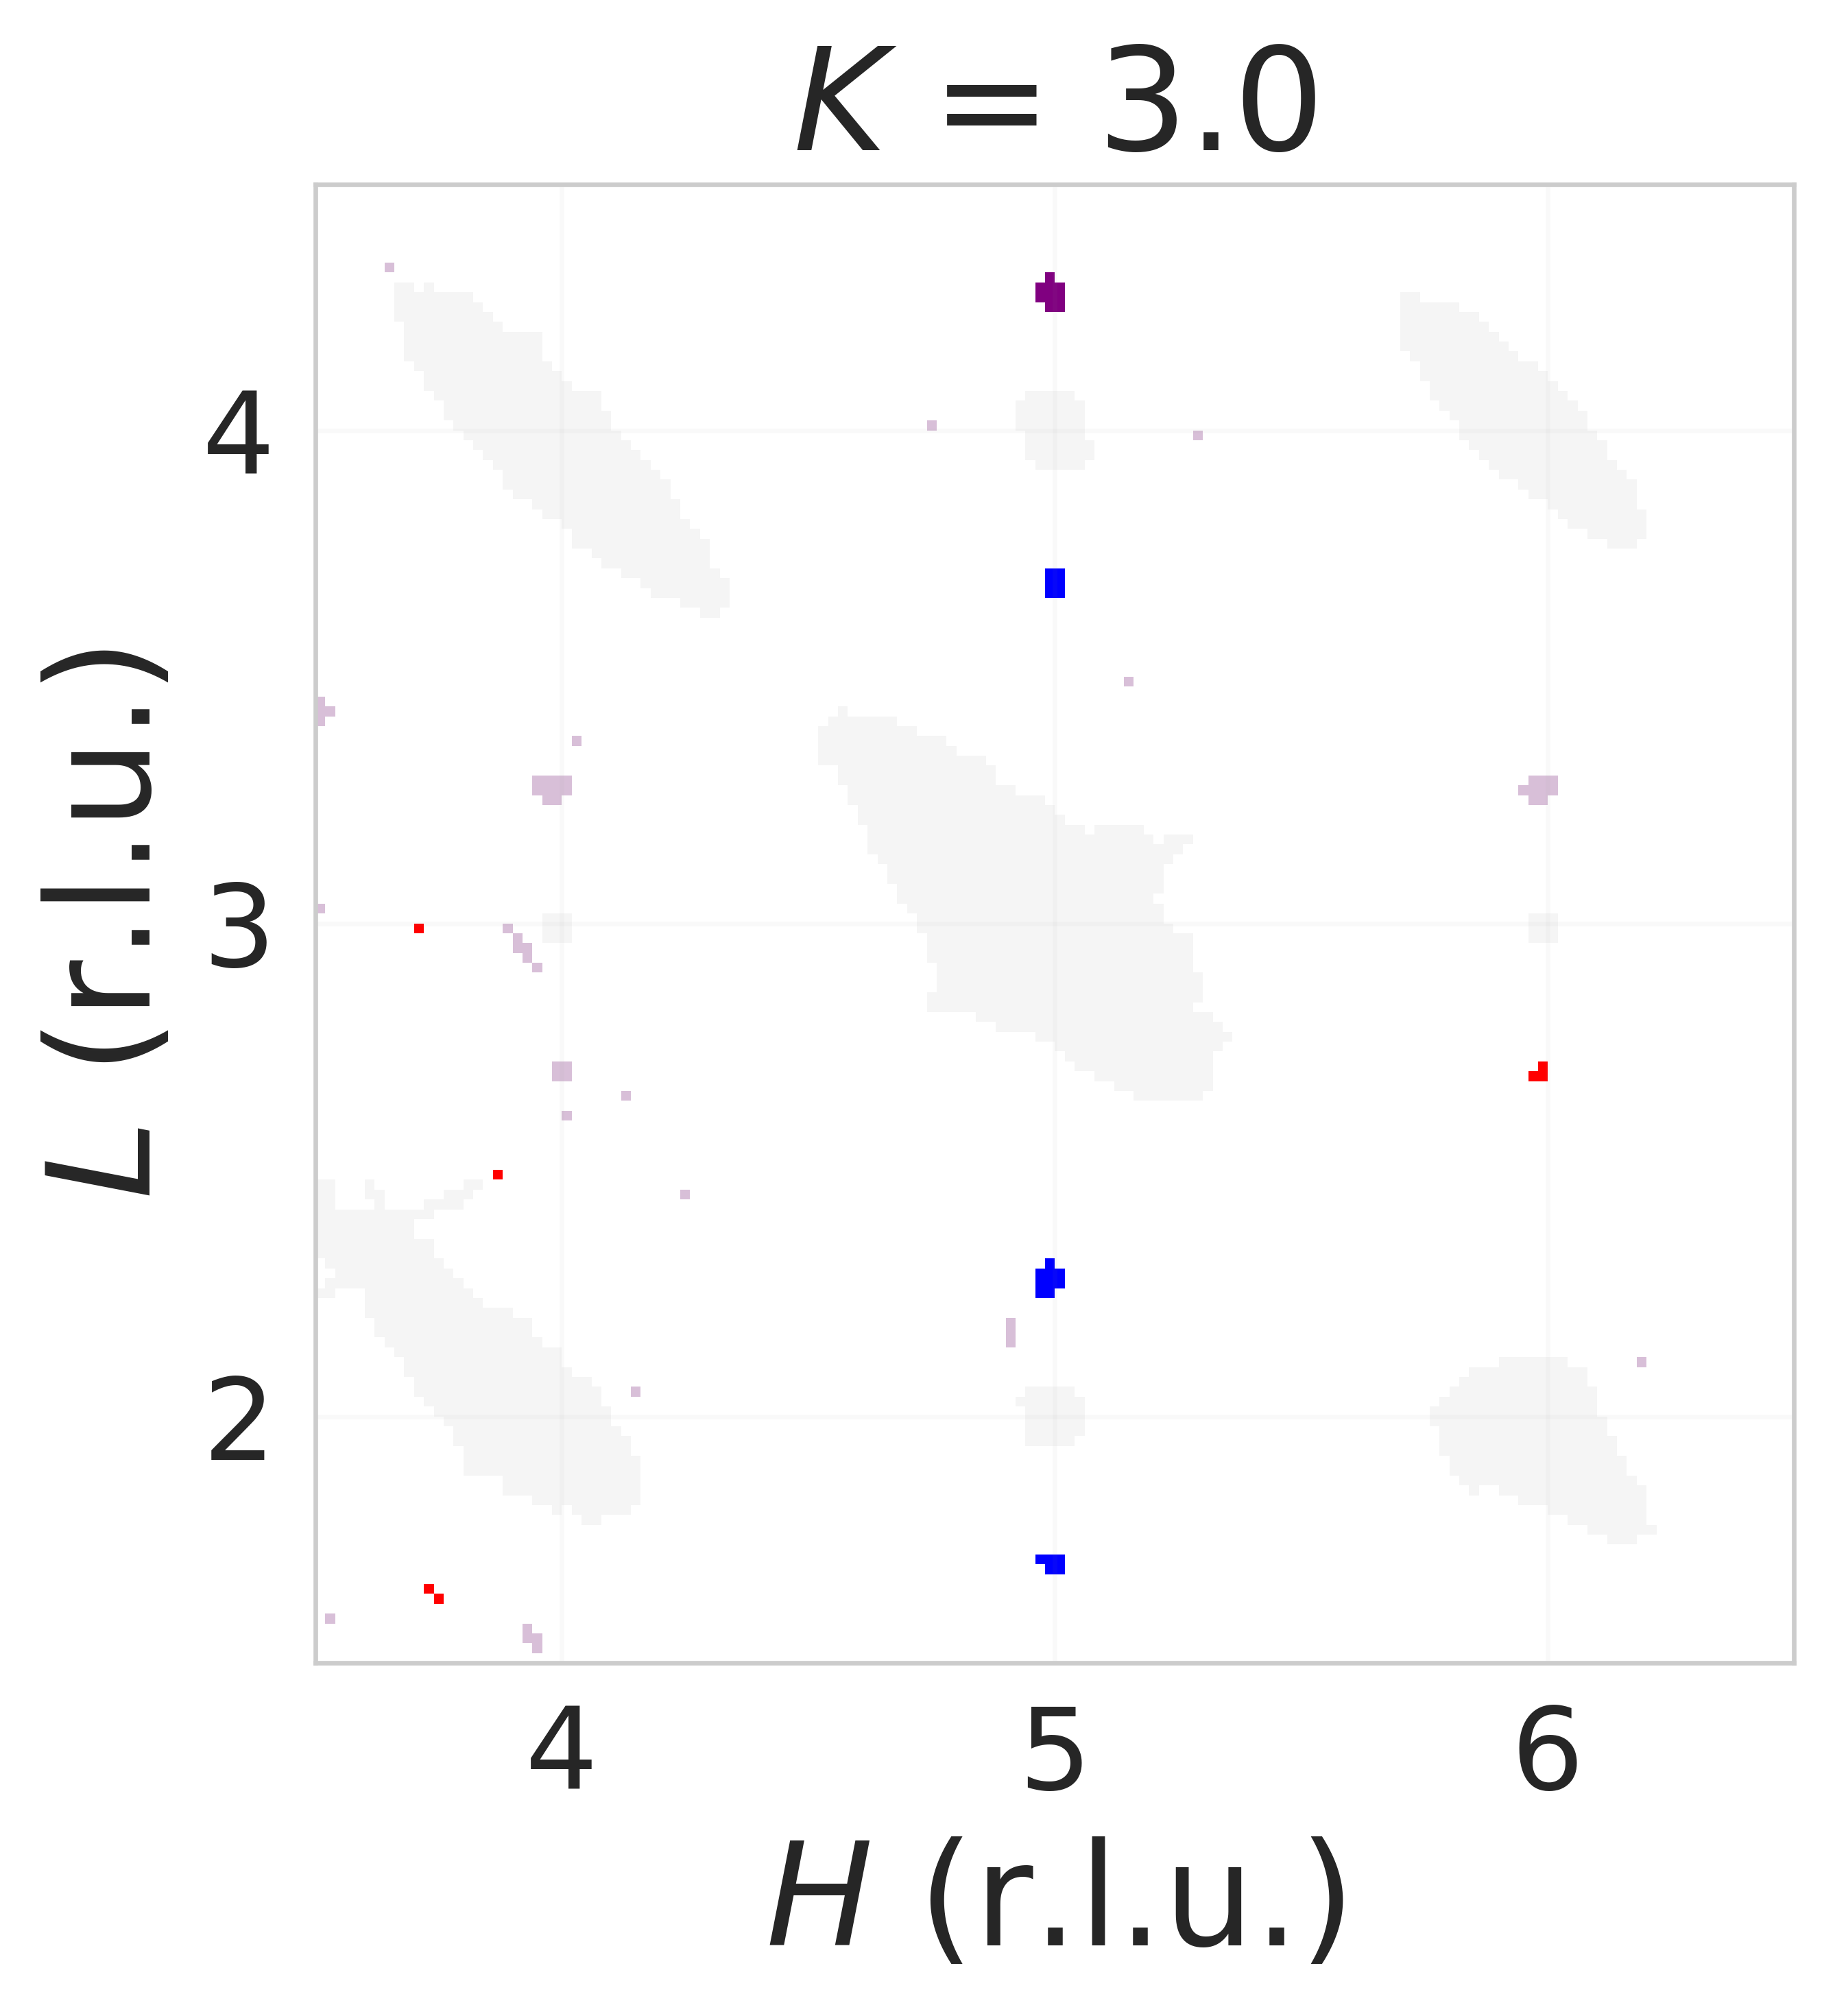

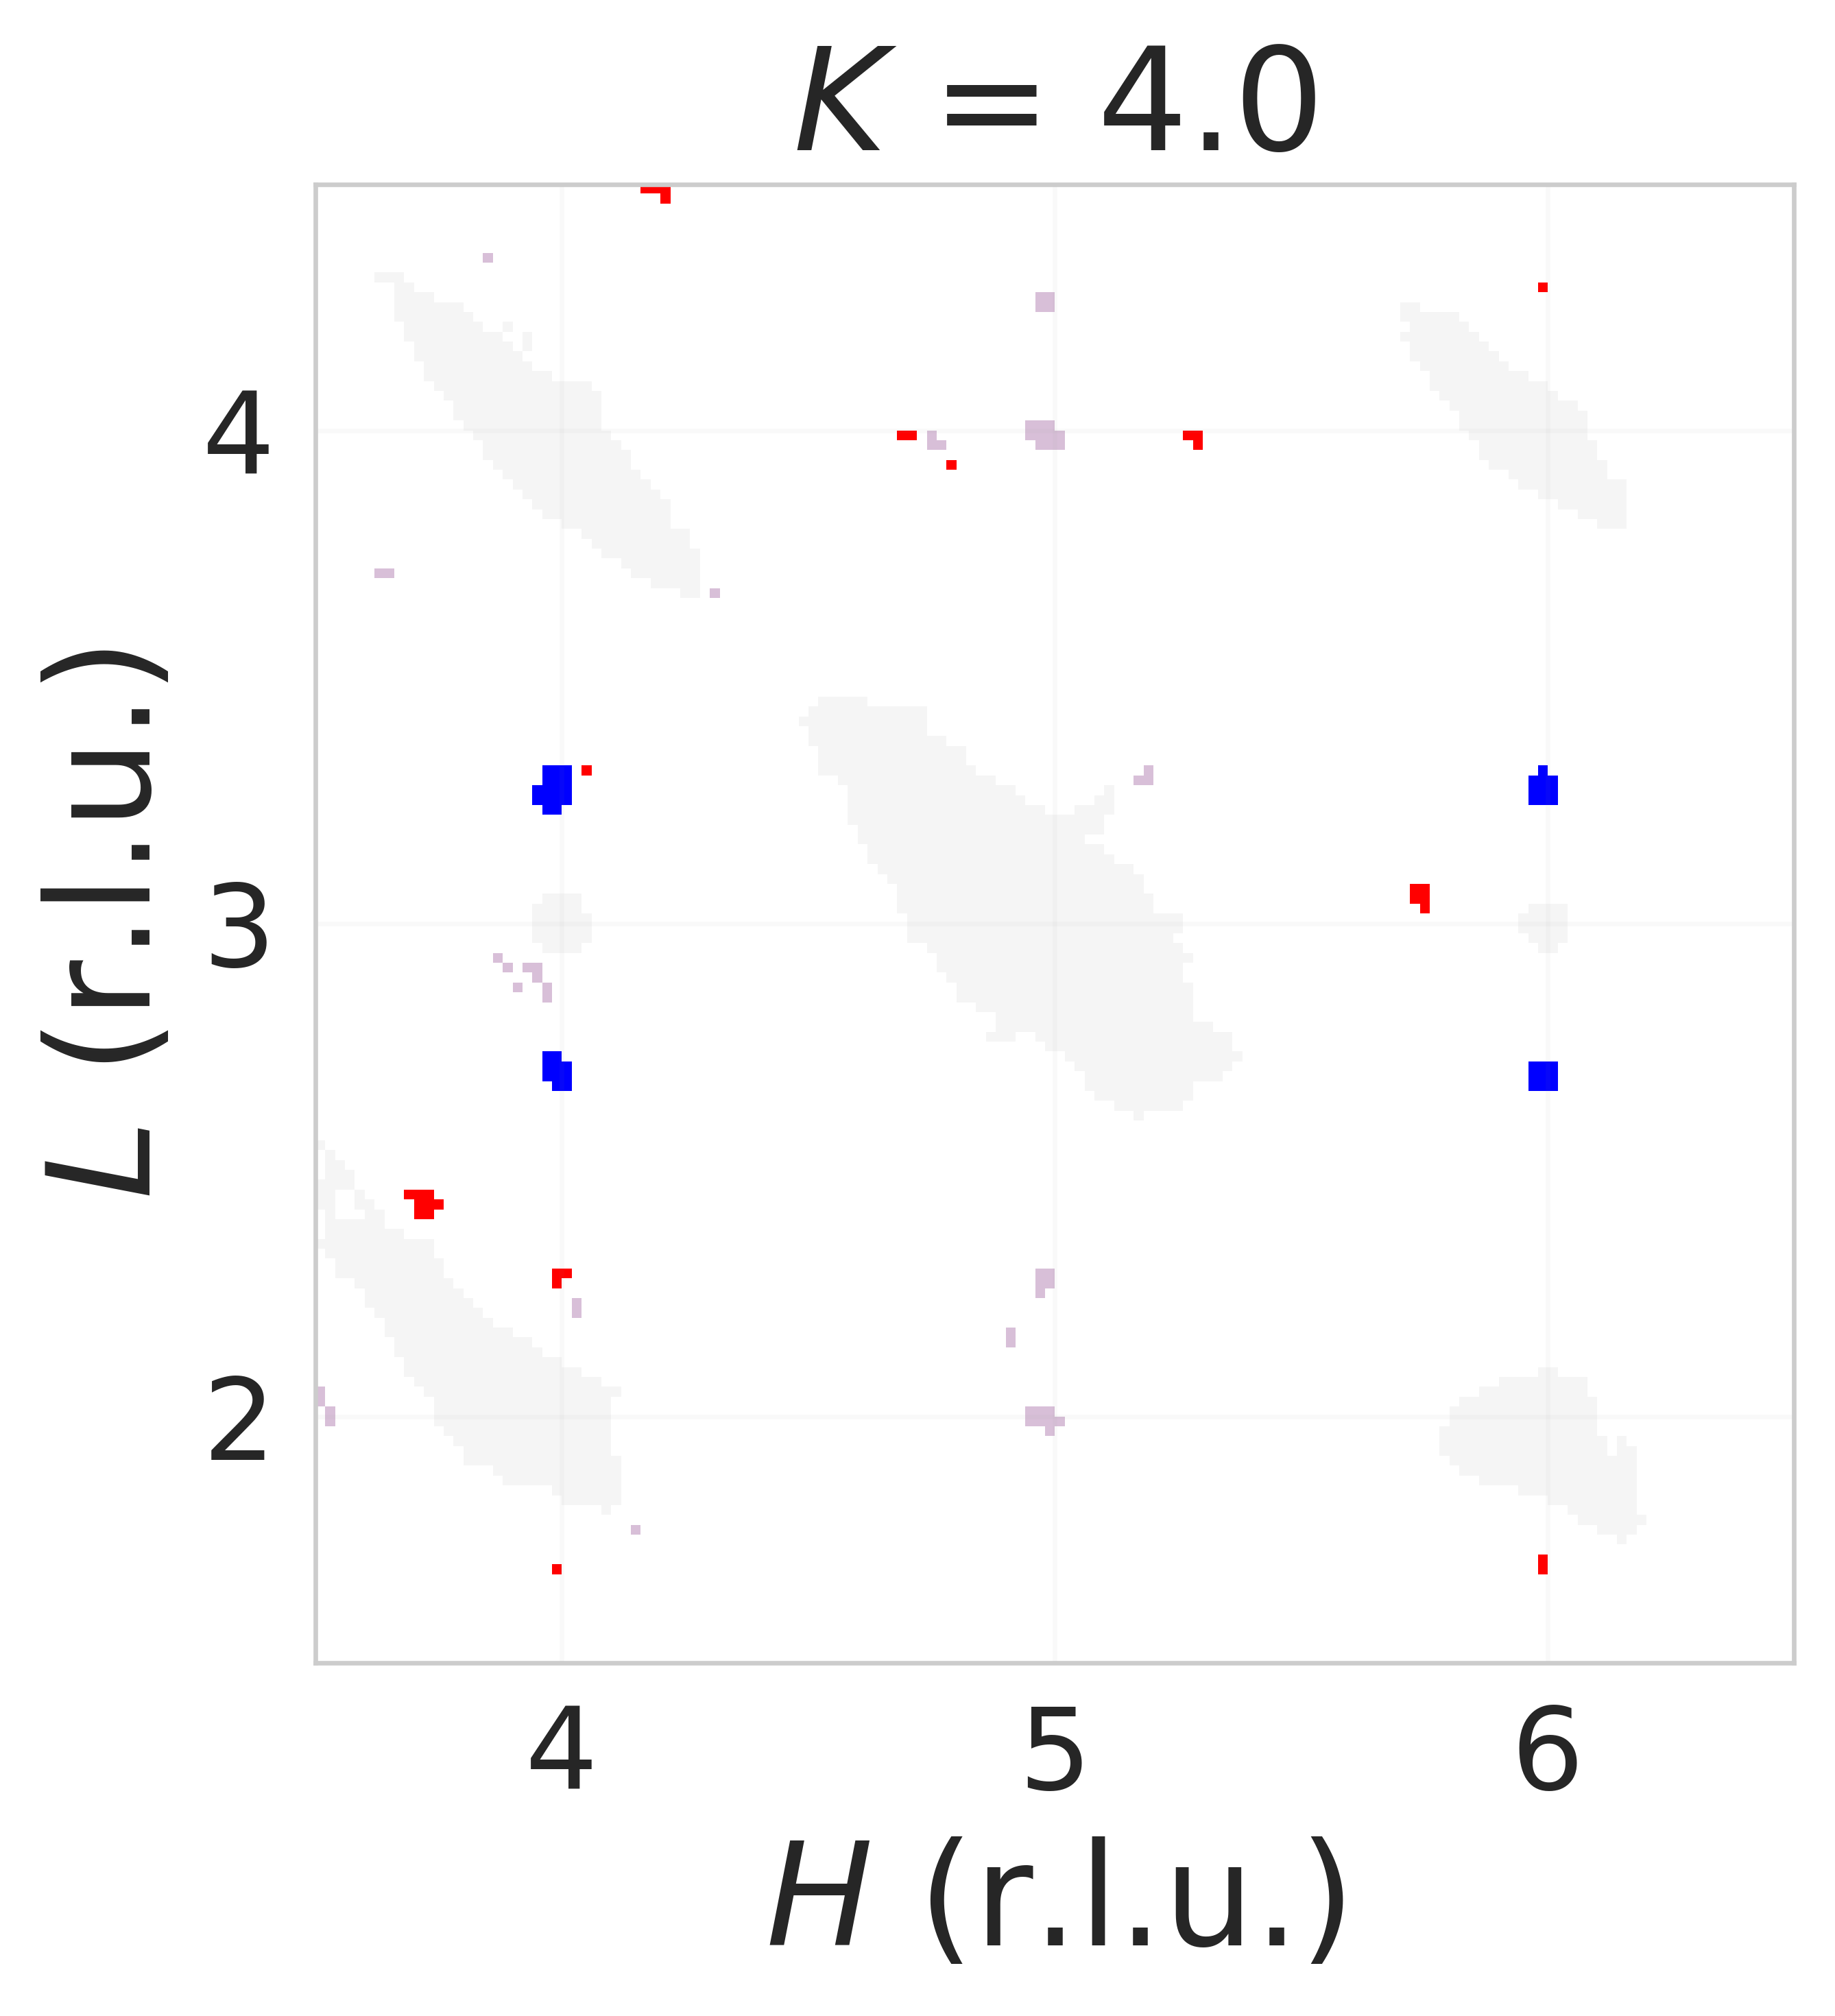

In [97]:
plot_slice(50)

plot_slice(51)
plot_slice(52)
plot_slice(53)


# Find momentum distribution of each cluster in 1BZ

In [131]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})

def plot_1BZ_dist(H_axis=True):
    if(H_axis):
        Q=Qh[NB_mom[:,1].astype(int)]+0.5
        xlabel='H (reduced zone)'
    else:
        Q=Ql[NB_mom[:,0].astype(int)]+0.5
        xlabel='L (reduced zone)'

    Q_1BZ=np.mod(Q,1)-0.5

        


    for i in range(clusterGMM.cluster_num):
        cluster_mask_i = (clusterGMM.cluster_assignments == i)
        yc=Q_1BZ[cluster_mask_i]
        
        plt.figure(figsize=(3,2))
    
        sns.histplot(data=yc, stat='probability',bins=25, color=color_list[i])
    
        
        plt.xlabel(xlabel,size=20)
        plt.ylabel('Prob',size=20)
        plt.ylim([0,0.5])
        plt.xlim([-0.5,0.5])
        plt.xticks(np.arange(-0.29,0.29+0.1,0.29),[-0.29,0,0.29],size=18)
        plt.yticks(size=18)
    
        ax=plt.gca()
        ax.yaxis.grid(False) # Hide the horizontal gridlines
        ax.xaxis.grid(True)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))

    

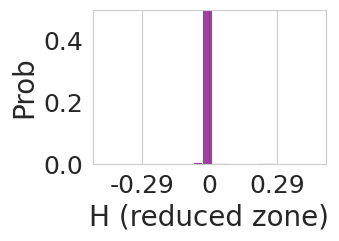

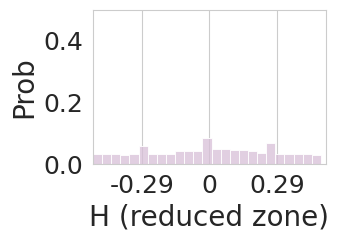

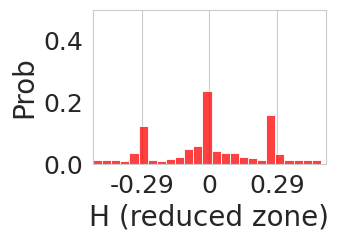

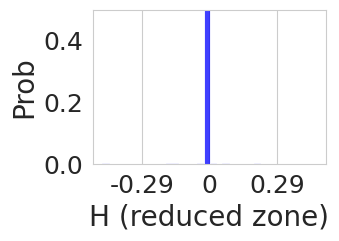

In [132]:
plot_1BZ_dist(H_axis=True)

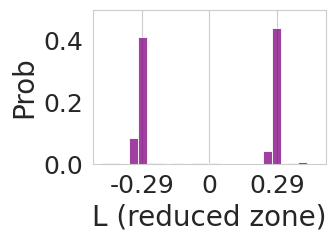

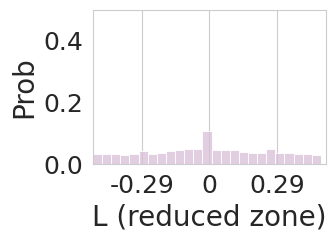

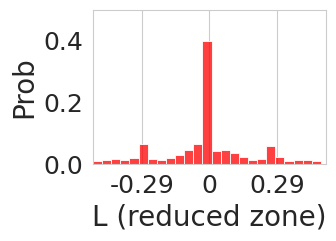

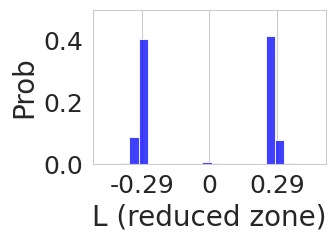

In [133]:
plot_1BZ_dist(H_axis=False)

In [28]:
np.min(np.std(data_post_thresh,axis=0))

0.005029127359008334